In [86]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
from pandas_datareader import data as web
import os 
import pickle
import numpy as np
from collections import Counter
from nsepy import get_history
from finta import TA
import copy
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt
import backtrader.feeds as btfeeds 
import argparse



style.use('ggplot')
%matplotlib qt

In [97]:
class PandasData(bt.feeds.DataBase):
    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''

    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', -1),
    )

Starting Portfolio Value: 1000000.00
2020-03-25, Close, 16861.35
2020-03-25, BUY CREATE, 16019.00
2020-03-26, BUY EXECUTED, Price: 16860.00, Cost: 16860.00, Comm 16.86
2020-03-26, Close, 17939.85
2020-03-26, BUY CREATE, 16860.00
2020-03-27, BUY EXECUTED, Price: 18500.00, Cost: 18500.00, Comm 18.50
2020-03-27, Close, 17648.60
2020-03-27, BUY CREATE, 18500.00
2020-03-30, BUY EXECUTED, Price: 17210.00, Cost: 17210.00, Comm 17.21
2020-03-30, Close, 17436.35
2020-03-31, Close, 18827.95
2020-03-31, BUY CREATE, 17799.90
2020-04-01, BUY EXECUTED, Price: 19080.05, Cost: 19080.05, Comm 19.08
2020-04-01, Close, 18469.55
2020-04-01, BUY CREATE, 19080.05
2020-04-03, BUY EXECUTED, Price: 18410.00, Cost: 18410.00, Comm 18.41
2020-04-03, Close, 17490.10
2020-04-07, Close, 18755.70
2020-04-08, Close, 18318.20
2020-04-09, Close, 18941.85
2020-04-13, Close, 18766.75
2020-04-15, Close, 18872.80
2020-04-16, Close, 19605.15
2020-04-16, BUY CREATE, 18885.00
2020-04-17, BUY EXECUTED, Price: 19999.00, Cost: 19

<IPython.core.display.Javascript object>


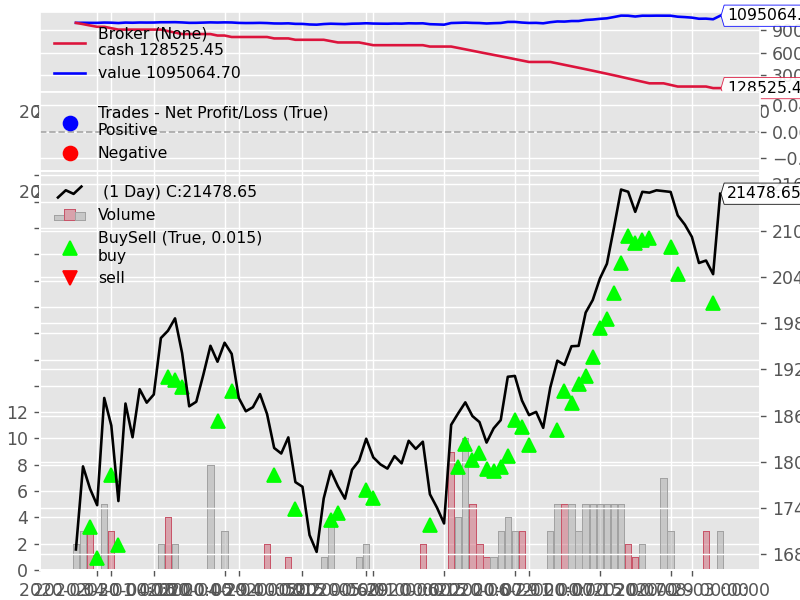

Final Portfolio Value: 1095064.70


In [122]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt


# Create a Stratey
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        print(self.datas[0].close)
        self.dataclose = self.datas[0].close
        self.datavolume = self.datas[0].volume
        self.dataopen = self.datas[0].open
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        #print(self.datavolume[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market

        if self.datavolume[0] > 0:
            self.log('BUY CREATE, %.2f' % self.dataopen[0])
            # Keep track of the created order to avoid a 2nd order
            self.order = self.buy()

if __name__ == '__main__':
    
    # Create a cerebro entity

    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Get a pandas dataframe
    datapath = 'stocks_dfs/3MINDIA.csv'
    dataframe = pd.read_csv(datapath, skiprows=0, parse_dates=True, index_col=0)
    dataframe = dataframe.rename(columns={'Score': 'Volume','Volume': 'Score'})
    dataframe = dataframe[304:]
    #display(dataframe)
    data = bt.feeds.PandasData(dataname=dataframe)
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)
    # Set our desired cash start
    cerebro.broker.setcash(1000000.0)

    # Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=0.001)
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    cerebro.plot()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())